# Micro- and Macroeconomic Implications of Very Impatient Households

## Introduction

Buffer stock saving models of the kind implemented in $\texttt{ConsIndShockType}$ say that, if a standard ['Growth Impatience Condition'](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Growth-Modified-Conditions), holds:

\begin{eqnarray}
\newcommand{\Rfree}{\mathsf{R}}\newcommand{\DiscFac}{\beta}\newcommand{\PermGroFac}{\Gamma}\newcommand{\PermShk}{\psi}\newcommand{\CRRA}{\rho}
\left(\frac{(\Rfree\DiscFac)^{1/\CRRA}\mathbb{E}[\PermShk^{-1}]}{\PermGroFac}\right) & < & 1
\end{eqnarray}

then the _ratio_ of asets $\newcommand{\aLev}{\mathbf{a}}\aLev$ to permanent income $\newcommand{\pLev}{\mathbf{p}}\pLev$, $a=\aLev/\pLev$, has a target value $\newcommand{\aTarg}{\check{a}}\aTarg$ that depends on the consumer's preferences (relative risk aversion $\CRRA$, time preference $\DiscFac$) and circumstances (interest factor $\Rfree$, growth factor $\PermGroFac$, uncertainty about permanent income shocks $\sigma^{2}_{\PermShk}$).

If everyone had identical preferences and everyone were at their target $\check{a}$, then inequality in the level of $\aLev$ would be exactly the same as inequality in $\pLev$.

["The Distribution of Wealth and the Marginal Propensity to Consume"](http://econ.jhu.edu/people/ccarroll/papers/cstwMPC) (Carroll, Slacalek, Tokuoka, and White 2017; hereafter: "cstwMPC") shows that, when such a model is simulated and agents draw their idiosyncratic shocks (so, agents are _ex post_ heterogeneous -- see the definition in [Intro-To-HARK](http://github.com/econ-ark/PARK/tree/master/Intro-To-HARK.pdf)) -- asset inequality is indeed close to $\pLev$ inequality even though everyone is not always at exactly their target $a$.

But a large body of evidence shows that _actual_ inequality in assets is much greater than _actual_ inequality in permanent income.  Thus, to make a model that qualifies as what cstwMPC call a 'serious' microfounded macro model of consumption (one that matches the key facts _theory says_ should be first-order important), the model must be modified to incorporate some form of _ex ante_ heterogeneity: That is, there must be differences across people in $\DiscFac$ or $\Rfree$ or $\CRRA$ or $\PermGroFac$ or $\sigma^{2}_{\PermShk}$.

The most transparent and simplest of these to change is the time preference factor $\beta$.  So that is what the paper does.  The main results are:

1. The distribution of $\beta$ need not be particularly wide to match the extreme concentration of wealth: roughly 0.91 to 0.98 (annual); that is, the most impatient person discounts the future about 6 percentage points more per year than the most patient agent agent
2. With such a distribution of $\beta$, simulated agents' (annual) marginal propensity to consume (MPC) from transitory income shocks to income matches large body of microeconomic evidence that typically finds evidence of MPC's in the range of 0.2 to 0.6.  This is much better than RA macro models that typically yield MPC's in the range of 0.01 to 0.05.

While the most impatient agents in the cstwMPC model have fairly high MPCs (~0.6 annual), there is microeconomic evidence that a significant fraction of households have *even higher* MPCs than the model predicts, especially at the quarterly frequency.  This group of households is commonly referred to as "hand-to-mouth" -- they consume most of their transitory shocks to income not too long after they receive them (mostly within a quarter).  There are several reasons why a household could be hand-to-mouth, but one plausible explanation is that these households are *even more impatient* than estimated by cstwMPC for the most impatient agent.


### PROBLEM 
In this exercise, you will explore the micro- and macroeconomic implications of some households being *very impatient*. Specifically, you will address the following questions:

1. How does the distribution of the MPC change (relative to cstwMPC's baseline) if some simulated households are extremely impatient?  Do we observe a significant portion of hand-to-mouth households?
2. How does the distribution (and aggregate level) of wealth change if some households are extremely impatient?  Does this distribution of $\beta$ still generate a wealth distribution like the one seen in U.S. data?

In [1]:
# This cell does some setup and imports generic tools used to produce the figures

import sys 
import os
sys.path.insert(0, os.path.abspath('../lib'))

from util import log_progress
import numpy as np
from copy import deepcopy

import HARK # Prevents import error from Demos repo
from HARK.utilities import plotFuncs


Generator=False # Is this notebook the master or is it generated?
# Import related generic python packages

# Set how many digits past the decimal point should be printed?
from time import clock
mystr   = lambda number : "{:.4f}".format(number)
decfmt4 = lambda number : "{:.4f}".format(number)
decfmt3 = lambda number : "{:.3f}".format(number)
decfmt2 = lambda number : "{:.2f}".format(number)
decfmt1 = lambda number : "{:.1f}".format(number)

# This is a jupytext paired notebook that autogenerates BufferStockTheory.py
# which can be executed from a terminal command line via "ipython BufferStockTheory.py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"

from IPython import get_ipython # In case it was run from python instead of ipython
def in_ipynb():
    try:
        if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
            return True
        else:
            return False
    except NameError:
        return False

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline')
else:
    get_ipython().run_line_magic('matplotlib', 'auto')

# Import the plot-figure library matplotlib

import matplotlib.pyplot as plt

# In order to use LaTeX to manage all text layout in our figures, we import rc settings from matplotlib.
from matplotlib import rc
plt.rc('font', family='serif')

# LaTeX is huge and takes forever to install on mybinder
# so if it is not installed then do not use it 
from distutils.spawn import find_executable
iflatexExists=False
if find_executable('latex'):
    iflatexExists=True
    
plt.rc('text', usetex= iflatexExists)

# The warnings package allows us to ignore some harmless but alarming warning messages
import warnings
warnings.filterwarnings("ignore")

from copy import copy, deepcopy

## Calibrating a Basic Version of cstwMPC

To get started, let's reproduce a simplified version of the main results from cstwMPC.  

In cstwMPC, the authors calibrated nearly all of the model parameters-- risk aversion, income shock process, etc-- to commonly used or previously estimated values.  The only parameter to be estimated is the distribution of $\beta$.  cstwMPC assumed that $\beta$ is uniformly distributed on $[\grave{\beta}-\nabla,\grave{\beta}+\nabla]$, approximated by a seven point distribution.

Their estimation procedure seeks the values of $\grave{\beta}$ and $\nabla$ that generate a simulated distribution of wealth that best matches empirical U.S. data.  Their definition of "best match" has two aspects:

1. The simulated aggregate capital-to-income ratio matches the true U.S. value.
2. The sum of squared distances between the simulated and empirical Lorenz curves (at the 20th, 40th, 60th, and 80th percentiles) is minimized (conditional on item 1).

cstwMPC's target empirical moments are a capital-to-income ratio of 10.26 and cumulative wealth shares as given in the table below.  Yes, you are reading the table correctly: The "poorest" 80 percent of households own 17.5 percent of wealth. 

| Net worth percentile | Cumulative wealth share |
|:---:|:---:|
|  20th  | -0.2% |
|  40th  | 1.0% |
|  60th  | 5.5% |
|  80th  | 17.5% |

To reproduce their basic results, we must import an $\texttt{AgentType}$ subclass and define a dictionary with calibrated parameters identical to those in the paper.

In [2]:
# Import IndShockConsumerType
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

# Define a dictionary with calibrated parameters
cstwMPC_calibrated_parameters = {
    "CRRA":1.0,                    # Coefficient of relative risk aversion 
    "Rfree":1.01/(1.0 - 1.0/160.0), # Survival probability,
    "PermGroFac":[1.000**0.25], # Permanent income growth factor (no perm growth),
    "PermGroFacAgg":1.0,
    "BoroCnstArt":0.0,
    "CubicBool":False,
    "vFuncBool":False,
    "PermShkStd":[(0.01*4/11)**0.5],  # Standard deviation of permanent shocks to income
    "PermShkCount":5,  # Number of points in permanent income shock grid
    "TranShkStd":[(0.01*4)**0.5],  # Standard deviation of transitory shocks to income,
    "TranShkCount":5,  # Number of points in transitory income shock grid
    "UnempPrb":0.07,  # Probability of unemployment while working
    "IncUnemp":0.15,  # Unemployment benefit replacement rate
    "UnempPrbRet":None,
    "IncUnempRet":None,
    "aXtraMin":0.00001,  # Minimum end-of-period assets in grid
    "aXtraMax":40,  # Maximum end-of-period assets in grid
    "aXtraCount":32,  # Number of points in assets grid
    "aXtraExtra":[None],
    "aXtraNestFac":3,  # Number of times to 'exponentially nest' when constructing assets grid
    "LivPrb":[1.0 - 1.0/160.0],  # Survival probability
    "DiscFac":0.97,             # Default intertemporal discount factor; dummy value, will be overwritten
    "cycles":0,
    "T_cycle":1,
    "T_retire":0,
    'T_sim':1200,  # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
    'T_age': 400,
    'IndL': 10.0/9.0,  # Labor supply per individual (constant),
    'aNrmInitMean':np.log(0.00001),
    'aNrmInitStd':0.0,
    'pLvlInitMean':0.0,
    'pLvlInitStd':0.0,
    'AgentCount':10000,
}

Now let's make several instances of our class of agents and give them different values of $\beta$, following cstwMPC's estimated distribution.  In our specification of interest, we will use $\grave{\beta}=0.9855583$ and $\nabla = 0.0085$.

NB: Reported parameter estimates in cstwMPC use a model with aggregate shocks and wage and interest rates determined dynamically (a heterogeneous agents DSGE model); this is the $\texttt{AggShockConsumerType}$ in HARK.  The estimated parameters are slightly different in this exercise, as we are ignoring general equilibrium aspects and only using the $\texttt{IndShockConsumerType}$

In [3]:
# This cell constructs seven instances of IndShockConsumerType with different discount factors
from HARK.utilities import approxUniform
BaselineType = IndShockConsumerType(**cstwMPC_calibrated_parameters)

# Specify the distribution of the discount factor
num_types = 7              # number of types we want
DiscFac_mean   = 0.9855583 # center of beta distribution 
DiscFac_spread = 0.0085    # spread of beta distribution
DiscFac_dstn = approxUniform(num_types, DiscFac_mean-DiscFac_spread, DiscFac_mean+DiscFac_spread)[1]

MyTypes = [] # initialize an empty list to hold our consumer types
for nn in range(num_types):
    # Now create the types, and append them to the list MyTypes
    NewType = deepcopy(BaselineType)
    NewType.DiscFac = DiscFac_dstn[nn]
    NewType.seed = nn # give each consumer type a different RNG seed
    MyTypes.append(NewType)

## Solving and Simulating the Baseline Agents

Now let's solve and simulate each of our types of agents.  If you look in the parameter dictionary (or at any of the agent objects themselves), you will see that each one has an $\texttt{AgentCount}$ attribute of 10000. That is, these seven ex ante heterogeneous types each represent ten thousand individual agents that will experience ex post heterogeneity when they draw different income (and mortality) shocks over time.

In the code block below, fill in the contents of the loop to solve and simulate each agent type for many periods.  To do this, you should invoke the methods $\texttt{solve}$, $\texttt{initializeSim}$, and $\texttt{simulate}$ in that order.  Simulating for 1200 quarters (300 years) will approximate the long run distribution of wealth in the population. 

In [4]:
# Progress bar keeps track interactively of how many have been made
for ThisType in log_progress(MyTypes, every=1):
    ThisType.solve()
    ThisType.initializeSim()
    ThisType.simulate()

To verify that you wrote that code correctly, let's check that the aggregate level of capital (total assets held by all households) to income ratio equals what we expected it would be.  To do that, let's combine the asset holdings of all types, take the mean, and see if we get the desired capital to income ratio of 10.26.

NB: Because there is no permanent income growth in this model, all shocks are mean one and idiosyncratic, and we have many agents, aggregate or average income is 1.0. 

In [5]:
aLvl_all = np.concatenate([ThisType.aLvlNow for ThisType in MyTypes])
print('The ratio of aggregate capital to permanent income is ' + decfmt2(np.mean(aLvl_all)))

The ratio of aggregate capital to permanent income is 10.26


## Plotting the Lorenz Curve

## Calculating the Lorenz Distance at Targets

Now we want to construct a function that calculates the Euclidean distance between simulated and actual Lorenz curves at the four percentiles of interest: 20, 40, 60, and 80.  

### PROBLEM - Create a Function to Calculate Lorenz Distance
Now let's write a function that calculates the Euclidean distance between simulated and actual Lorenz curves at the four percentiles of interest: 20, 40, 60, and 80.  Fill in the skeleton of the function below, and then test your function using the input $\texttt{MyTypes}$.  If you did it correctly, the Lorenz distance should be 0.03.

You may find it useful to check out some documentation for $\texttt{HARK.utilities}$ [at this link](https://econ-ark.github.io/HARK/generated/HARKutilities.html).

In [7]:
from HARK.utilities import getLorenzShares, getPercentiles
from HARK.cstwMPC.SetupParamsCSTW import SCF_wealth, SCF_weights

pctiles=np.array([0.2,0.4,0.6,0.8])

lorenz_sim = getLorenzShares(aLvl_all,percentiles=pctiles)
lorenz_scf = getLorenzShares(SCF_wealth,weights=SCF_weights,percentiles=pctiles)

lorenz_act = np.zeros([1,4])

def LorenzDistance(points1,points2):
    distance = np.sqrt(np.sum((points1-points2)**2))
    return distance 

print('The Euclidean distance between simulated and actual Lorenz curves is '+str(LorenzDistance(lorenz_sim,lorenz_act))) 

The Euclidean distance between simulated and actual Lorenz curves is 0.204892146952


In [10]:
#lorenz_sim 
#lorenz_scf

array([ -6.78994125e-05,   1.39889470e-03,   7.94390800e-03,
         3.66748117e-02])

## The Distribution Of the Marginal Propensity to Consume

For many macroeconomic purposes, the distribution of the MPC $\kappa$ is more important than the distribution of wealth.  Ours is a quarterly model, and MPC's are typically reported on an annual basis; we can compute an approximate MPC from the quraterly ones as $\kappa_{Y} \approx 1.0 - (1.0 - \kappa_{Q})^4$

In the cell below, we retrieve the MPCs from our simulated consumers and show that the 10th percentile in the MPC distribution is only about 6 percent, while at the 90th percentile it is almost 0.5

In [7]:
# Retrieve the MPC's
percentiles=np.linspace(0.1,0.9,9)
MPC_sim = np.concatenate([ThisType.MPCnow for ThisType in MyTypes])
MPCpercentiles_quarterly = getPercentiles(MPC_sim,percentiles=percentiles)
MPCpercentiles_annual = 1.0 - (1.0 - MPCpercentiles_quarterly)**4

print('The MPC at the 10th percentile of the distribution is '+str(decfmt2(MPCpercentiles_annual[0])))
print('The MPC at the 50th percentile of the distribution is '+str(decfmt2(MPCpercentiles_annual[4])))
print('The MPC at the 90th percentile of the distribution is '+str(decfmt2(MPCpercentiles_annual[-1])))

The MPC at the 10th percentile of the distribution is 0.06
The MPC at the 50th percentile of the distribution is 0.20
The MPC at the 90th percentile of the distribution is 0.49


### PROBLEM

Now let's look in more detail at the distribution of the MPC.  In the code block below, write a function that produces text output of the following form:

$\texttt{The 35th percentile of the MPC is 0.15623}$

Your function should take two inputs: a list of types of consumers and an array of percentiles (numbers between 0 and 1). It should return no outputs, merely print to screen one line of text for each requested percentile.  The model is calibrated at a quarterly frequency, but Carroll et al report MPCs at an annual frequency. To convert, use the formula:

$\kappa_{Y} \approx 1.0 - (1.0 - \kappa_{Q})^4$

### SOLUTION



In [8]:
def MPC_percentile_report(MyTypes,pctiles):
    MPC_sim = np.concatenate([ThisType.MPCnow for ThisType in MyTypes])
    MPC_q = getPercentiles(MPC_sim,percentiles=pctiles)
    MPC_y = 1-(1-MPC_q)**4
    for i in range(len(pctiles)):
        print('The MPC at the '+str(int(pctiles[i]*100))+'th ' +'percentile of the distribution is '+str(MPC_y[i]))
    
MPC_percentile_report(MyTypes,pctiles)

The MPC at the 20th percentile of the distribution is 0.0669027747285
The MPC at the 40th percentile of the distribution is 0.115577636997
The MPC at the 60th percentile of the distribution is 0.265134073362
The MPC at the 80th percentile of the distribution is 0.40048447591


## Adding Very Impatient Households

Now that we have some tools for examining both microeconomic (the MPC across the population) and macroeconomic (the distribution and overall level of wealth) outcomes from our model, we are all set to conduct our experiment.

In this exercise, we are going to add very impatient households to the economy in a very direct way: by replacing the *most impatient consumer type* with an *even more impatient type*.  Specifically, we will have these agents have a discount factor of $\beta = 0.80$ at a quarterly frequency, which corresponds to $\beta \approx 0.41$ annual.

In the code block below, we:

1. Replicate the list of agents using $\texttt{deepcopy}$.
2. Set the $\beta$ of the most impatient type to $0.80$ (for the copied set of agents).
3. Solve and simulate the most impatient type (for the copied set of agents).

In [9]:
# Follow the instructions above to make another list of agents that includes *very* impatient households.
NewTypes = deepcopy(MyTypes)
NewTypes[0].DiscFac = 0.8
NewTypes[0].solve()
NewTypes[0].initializeSim()
NewTypes[0].simulate()

# Retrieve the MPC's
percentiles=np.linspace(0.1,0.9,9)
MPC_sim = np.concatenate([ThisType.MPCnow for ThisType in NewTypes])
MPCpercentiles_quarterly = getPercentiles(MPC_sim,percentiles=percentiles)
MPCpercentiles_annual = 1.0 - (1.0 - MPCpercentiles_quarterly)**4

print('The MPC at the 10th percentile of the distribution is '+str(decfmt2(MPCpercentiles_annual[0])))
print('The MPC at the 50th percentile of the distribution is '+str(decfmt2(MPCpercentiles_annual[4])))
print('The MPC at the 90th percentile of the distribution is '+str(decfmt2(MPCpercentiles_annual[-1])))

The MPC at the 10th percentile of the distribution is 0.06
The MPC at the 50th percentile of the distribution is 0.20
The MPC at the 90th percentile of the distribution is 0.97


### PROBLEM
## Testing the Implications of Very Impatient Households

Now that we have the baseline set of simulated agents (in $\texttt{MyTypes}$) and the altered set of simulated agents (in whatever you named your copied version), let's investigate what this means for micro- and macroeconomic outcomes.  In the code block below, use both lists of agents and the data tools you wrote above to investigate the following questions:

1. Did introducing very impatient households generate a substantial proportion of hand-to-mouth households?
   - Define 'hand to mouth' as households whose quarterly MPC is greater than 0.7
2. Did introducing very impatient households affect the simulated model's ability to match the empirical distribution of wealth and its aggregate level?
3. Much of the "behavioral" consumption literature concludes, when consumers are found to have very high MPC's, that the standard optimal consumption model "doesn't work" 
   * Given what you have found, can you reject the hypothesis that hand-to-mouth households arise in the data because they are very impatient?

Use the markdown block below the code block to briefly answer those questions.

### SOLUTION

In [17]:
pctile_fine = np.linspace(0.1,0.9,36)
MPC_percentile_report(NewTypes,pctile_fine)

The MPC at the 10th percentile of the distribution is 0.0571779419614
The MPC at the 12th percentile of the distribution is 0.0582798059284
The MPC at the 14th percentile of the distribution is 0.0641718739223
The MPC at the 16th percentile of the distribution is 0.0662292630021
The MPC at the 19th percentile of the distribution is 0.0665198553645
The MPC at the 21th percentile of the distribution is 0.0673095521006
The MPC at the 23th percentile of the distribution is 0.0677018737413
The MPC at the 26th percentile of the distribution is 0.0690553903882
The MPC at the 28th percentile of the distribution is 0.0767104701707
The MPC at the 30th percentile of the distribution is 0.0781501850691
The MPC at the 32th percentile of the distribution is 0.0805081660941
The MPC at the 35th percentile of the distribution is 0.0826894754005
The MPC at the 37th percentile of the distribution is 0.0921524282069
The MPC at the 39th percentile of the distribution is 0.11095354262
The MPC at the 42th pe

1. From above we can see there is at least 17% of the population are hand-to-mouth once we add very impatient type. This is a significant increase in the proportion of hand-to-mouth consumers as without the very impatient type, less than 5% population is hand-to-mouth.


In [22]:
aLvl_all_new = np.concatenate([ThisType.aLvlNow for ThisType in NewTypes])
lorenz_baseline = getLorenzShares(aLvl_all,percentiles=pctiles)
lorenz_new = getLorenzShares(aLvl_all_new,percentiles=pctiles)
LorenzDistance(lorenz_baseline,lorenz_new)

0.019446635392165259

### PROBLEM -- Plot the new distribution of wealth

The $\texttt{matplotlib}$ library provides plotting functionality that replicates Matlab's plot features (more or less). As an example of how to use it, we have written a few lines of code that plot the empirical vs simulated Lorenz curves.  Write some code that plots the CDF of the MPC before and after adding very impatient households, and plots the DIFFERENCES between the Lorenz curves across the two populations.  Interpret the two graphs.

### SOLUTION

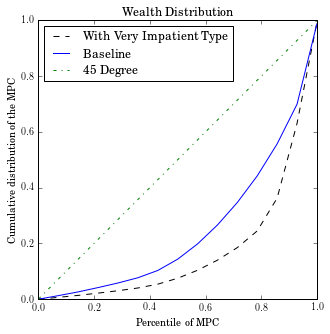

In [24]:
baseline_MPC = np.concatenate([ThisType.MPCnow for ThisType in MyTypes])
new_MPC =  np.concatenate([ThisType.MPCnow for ThisType in NewTypes])

pctiles = np.linspace(0.001,0.999,15)
baseline_Lorenz_points = getLorenzShares(baseline_MPC,percentiles=pctiles)
new_Lorenz_points = getLorenzShares(new_MPC,percentiles=pctiles)

## Plot
plt.figure(figsize=(5,5))
plt.title('Wealth Distribution')
plt.plot(pctiles,new_Lorenz_points,'--k',label='With Very Impatient Type')
plt.plot(pctiles,baseline_Lorenz_points,'-b',label='Baseline')
plt.plot(pctiles,pctiles,'g-.',label='45 Degree')
plt.xlabel('Percentile of MPC')
plt.ylabel('Cumulative distribution of the MPC')
plt.legend(loc=2)
plt.ylim([0,1])
plt.show()

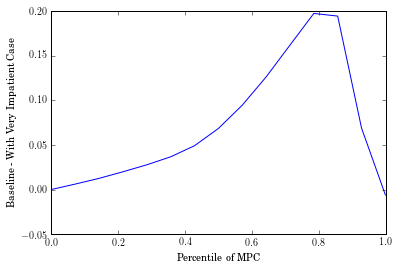

In [27]:
diff_lorenz = baseline_Lorenz_points-new_Lorenz_points

plt.plot(pctiles,diff_lorenz)
plt.ylabel('Baseline - With Very Impatient Case')
plt.xlabel('Percentile of MPC')

In [26]:
print('The Euclidean distance between the baseline and one with very impatient type Lorenz curves in MPC is '+str(LorenzDistance(baseline_Lorenz_points,new_Lorenz_points)))  

The Euclidean distance between the baseline and one with very impatient type Lorenz curves in MPC is 0.377201452106


### Solution, cont'd 
There is a significance increase in the difference of the Lorenz curve of MPC in high percentiles.This implies more people are shifted toward a high MPCs in the population.